In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_dir = '/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/Images/'

print(os.listdir(data_dir))

['With UPC', 'Without UPC', 'ObjectDetection']


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
print(tf.__version__)

2.4.1


In [ ]:
image_size = (224, 224)
# image_size = (600, 600)

batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/train_G",
    validation_split=0.1,
    subset="training",
    seed=1337,
    label_mode = 'categorical',
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/Test",
    # validation_split=0.2,
    # subset="validation",
    seed=1337,
    label_mode = 'categorical',
    image_size=image_size,
    batch_size=batch_size,
)


Found 921 files belonging to 2 classes.
Using 829 files for training.
Found 100 files belonging to 2 classes.


In [ ]:
# train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
data_augmentation = keras.Sequential(
    [
        # layers.experimental.preprocessing.RandomFlip("horizontal"),
        # layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.Resizing(128,128)
    ]
)


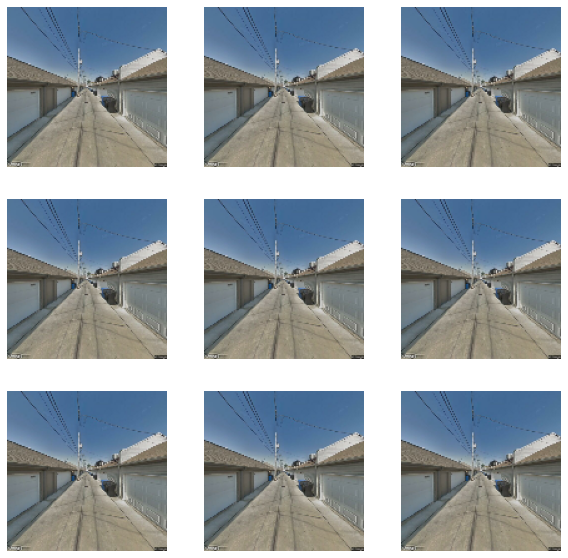

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
train_ds = train_ds.prefetch(buffer_size=5)
val_ds = val_ds.prefetch(buffer_size=5)


In [ ]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
# model.summary()



In [ ]:
def resnet_model(input_shape, num_classes):
    # inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    # x = data_augmentation(inputs)
    base_model = keras.applications.ResNet50(weights='imagenet', input_shape=input_shape)
    out_resnet = base_model.output
    res = layers.Dropout(0.5)(out_resnet)
    output = layers.Dense(num_classes, activation='softmax', name='softmax')(res)
    net_final = keras.Model(inputs=base_model.input, outputs=output)

    return net_final

resnet_model = resnet_model(input_shape=image_size + (3,), num_classes=2)
resnet_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
epochs = 50

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_Dan_{epoch}.h5"),

resnet_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    # loss="binary_crossentropy",
    metrics=["accuracy",f1_m,precision_m, recall_m],   #can try another loss function type
)
resnet_model.fit(train_ds, epochs=epochs, validation_data=val_ds)
resnet_model_name = resnet_model_name = "resnet_epoch_" + str(epochs) + ".h5"
resnet_model.save(resnet_model_name)


Epoch 1/50
26/26 [==============================] - 16s 382ms/step - loss: 0.5972 - accuracy: 0.8456 - f1_m: 0.8456 - precision_m: 0.8456 - recall_m: 0.8456 - val_loss: 0.6081 - val_accuracy: 0.8700 - val_f1_m: 0.8984 - val_precision_m: 0.8984 - val_recall_m: 0.8984
Epoch 2/50
26/26 [==============================] - 10s 352ms/step - loss: 0.5934 - accuracy: 0.8328 - f1_m: 0.8329 - precision_m: 0.8329 - recall_m: 0.8329 - val_loss: 0.5904 - val_accuracy: 0.9500 - val_f1_m: 0.9609 - val_precision_m: 0.9609 - val_recall_m: 0.9609
Epoch 3/50
26/26 [==============================] - 10s 358ms/step - loss: 0.5980 - accuracy: 0.8318 - f1_m: 0.8318 - precision_m: 0.8318 - recall_m: 0.8318 - val_loss: 0.5895 - val_accuracy: 0.9400 - val_f1_m: 0.9531 - val_precision_m: 0.9531 - val_recall_m: 0.9531
Epoch 4/50
26/26 [==============================] - 10s 362ms/step - loss: 0.5835 - accuracy: 0.8498 - f1_m: 0.8499 - precision_m: 0.8499 - recall_m: 0.8499 - val_loss: 0.6247 - val_accuracy: 0.7500 

In [ ]:
%ls

gdrive/  resnet_epoch_20.h5  resnet_epoch_50.h5  sample_data/


In [ ]:
import numpy as np

path_model="./resnet_epoch_50.h5"
resnet_model.load_weights(path_model)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/Shareddrives/ComED Codes and Data/Dataset/test_G",
    # validation_split=0.2,
    # subset="validation",
    label_mode = 'categorical',
    seed=1337,
    image_size=image_size,
    batch_size=1,
)

count_test_samples = len(test_ds)
print("Count test data:", count_test_samples)


predict_prob = []
label_list = []
for i in range(count_test_samples):
    for image, label in test_ds.take(1):
        [pred] = resnet_model.predict(image)
        label_list.append(np.float32(label)[0])
        predict_prob.append(pred)
    # showing the test resluts
    # if i == 8:
    #     print("predict_prob:", predict_prob)
    #     print("label_list:", label_list)
print("done!")
print("predict_prob:", predict_prob)
print("label_list:", label_list)


Found 104 files belonging to 2 classes.
Count test data: 104
done!
predict_prob: [array([0.2575407, 0.7424593], dtype=float32), array([0.25755093, 0.74244905], dtype=float32), array([0.2575407, 0.7424593], dtype=float32), array([0.2575407, 0.7424593], dtype=float32), array([0.5328306 , 0.46716937], dtype=float32), array([0.2575407, 0.7424593], dtype=float32), array([0.2575407, 0.7424593], dtype=float32), array([0.2575407, 0.7424593], dtype=float32), array([0.5192692 , 0.48073083], dtype=float32), array([0.25755093, 0.74244905], dtype=float32), array([0.5328301, 0.4671699], dtype=float32), array([0.5328306 , 0.46716937], dtype=float32), array([0.2575407, 0.7424593], dtype=float32), array([0.2575407, 0.7424593], dtype=float32), array([0.2575407, 0.7424593], dtype=float32), array([0.25755093, 0.74244905], dtype=float32), array([0.2575407, 0.7424593], dtype=float32), array([0.5328306 , 0.46716937], dtype=float32), array([0.5192692 , 0.48073083], dtype=float32), array([0.2575407, 0.7424593]

In [ ]:
pred_1 = []
label_1 = []
pred_2 = []
label_2 = []
for i in range(len(label_list)):
  pred_1.append(np.float16(predict_prob[i][0]))
  pred_2.append(np.float16(predict_prob[i][1]))

  label_1.append(np.float16(label_list[i][0]))
  label_2.append(np.float16(label_list[i][1]))

print ("pred_1: ", pred_1)
print ("label_1: ", label_1)


pred_1:  [0.2576, 0.2576, 0.2576, 0.2576, 0.5327, 0.2576, 0.2576, 0.2576, 0.519, 0.2576, 0.5327, 0.5327, 0.2576, 0.2576, 0.2576, 0.2576, 0.2576, 0.5327, 0.519, 0.2576, 0.519, 0.2576, 0.2576, 0.2576, 0.2576, 0.2576, 0.2576, 0.2576, 0.519, 0.2576, 0.2576, 0.2576, 0.2576, 0.2576, 0.5327, 0.519, 0.5327, 0.5327, 0.5327, 0.5327, 0.5327, 0.2576, 0.5327, 0.2576, 0.2576, 0.2576, 0.519, 0.2576, 0.2576, 0.2576, 0.2576, 0.2576, 0.5327, 0.2576, 0.2576, 0.5327, 0.2576, 0.5327, 0.2576, 0.2576, 0.2576, 0.2576, 0.2576, 0.2576, 0.2576, 0.519, 0.2576, 0.2576, 0.2576, 0.5327, 0.5327, 0.2576, 0.2576, 0.5327, 0.2576, 0.5327, 0.2576, 0.5327, 0.5327, 0.5327, 0.519, 0.2576, 0.2576, 0.2576, 0.2576, 0.519, 0.2576, 0.2576, 0.5327, 0.2576, 0.519, 0.5327, 0.5327, 0.2576, 0.5327, 0.519, 0.2576, 0.5327, 0.519, 0.2576, 0.2576, 0.2576, 0.2576, 0.2576]
label_1:  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,

threshold:  [0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427
 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427
 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427
 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427
 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427
 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427
 0.7427 0.7427 0.7427 0.7427 0.7427 0.7427 0.4807 0.4807 0.4807 0.4807
 0.4807 0.4807 0.4807 0.4807 0.4807 0.4807 0.4807 0.4807 0.4673 0.4673
 0.4673 0.4673 0.4673 0.4673 0.4673 0.4673 0.4673 0.4673 0.4673 0.4673
 0.4673 0.4673 0.4673 0.4673 0.4673 0.4673 0.4673 0.4673 0.4673 0.4673
 0.4673 0.4673 0.4673 0.4673]
tpr_lr:  [0, 0.015151515151515152, 0.030303030303030304, 0.045454545454545456, 0.06060606060606061, 0.07575757575757576, 0.09090909090909091, 0.10606060606060606, 0.12121212121212122, 0.13636363636363635, 0.1515151515151515, 0.16666666666666663, 0.

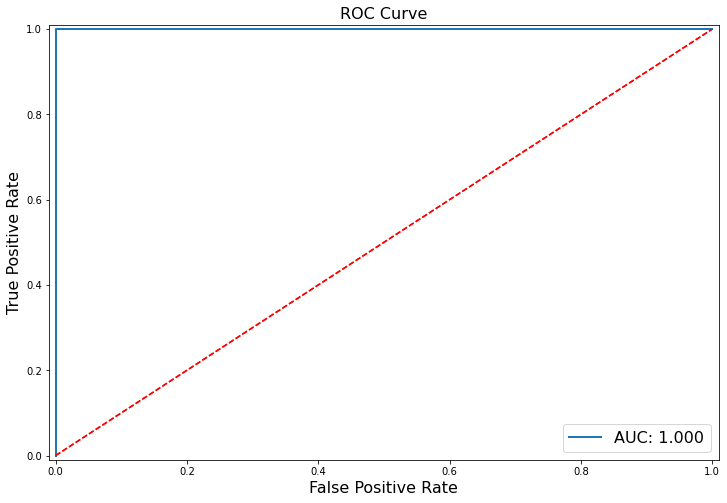

In [ ]:
#ROC plots and similar
import matplotlib.pylab as plt

def get_roc(pred_prob,y_true):
    pos = y_true[y_true==1]
    neg = y_true[y_true==0]
    threshold = np.sort(pred_prob)[::-1] 
    print("threshold: ", threshold)  
    y = y_true[pred_prob.argsort()[::-1]]
    tpr_all = [0] ; fpr_all = [0]
    tpr = 0 ; fpr = 0
    x_step = 1/float(len(neg))
    y_step = 1/float(len(pos))
    y_sum = 0                      
    for i in range(len(threshold)):
        if y[i] == 1:
            tpr += y_step
            tpr_all.append(tpr)
            fpr_all.append(fpr)
        else:
            fpr += x_step
            fpr_all.append(fpr)
            tpr_all.append(tpr)
            y_sum += tpr
    return tpr_all,fpr_all,y_sum*x_step


tpr_lr,fpr_lr,auc_lr = get_roc(np.array(pred_2),np.array(label_2))  
print("tpr_lr: ", tpr_lr)
print("fpr_lr: ", fpr_lr)
plt.figure(figsize=(12,8))
plt.plot(fpr_lr,tpr_lr,label="AUC: {:.3f}".format(auc_lr),linewidth=2)

plt.xlim([-0.01,1.01])
plt.ylim([-0.01,01.01])
plt.plot([(0,0),(1,1)],'r--')
plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.title("ROC Curve",fontsize=16)
plt.legend(loc="lower right",fontsize=16)
plt.show()


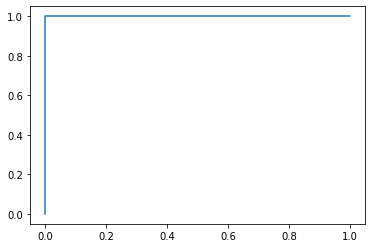

In [ ]:
plt.figure()
plt.plot(fpr_lr,tpr_lr)
plt.show()

#b = np.arange(5)
#print(b)

num of predicting sampels: 104
fpr:  [0. 0. 0. 1.]
tpr:  [0.         0.68421053 1.         1.        ]
thresholds:  [1.533  0.5327 0.519  0.2576]


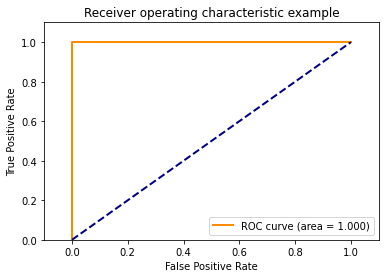

In [ ]:
# Second ROC
print("num of predicting sampels:", len(predict_prob))
from sklearn import metrics
np_label = np.array(label_1)
np_pred = np.array(pred_1)
fpr, tpr, thresholds = metrics.roc_curve(np_label, np_pred)
print("fpr: ", fpr)
print("tpr: ", tpr)
print("thresholds: ", thresholds)

auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.1, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Precision Recall Curve')

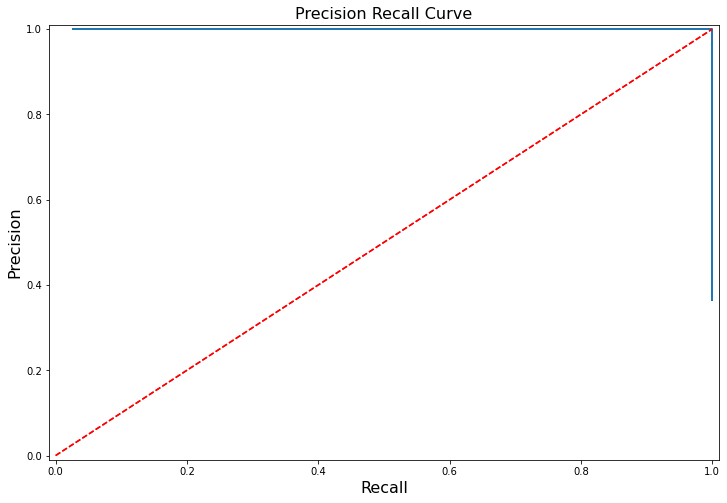

In [ ]:
# PR curve
def get_pr(pred_prob,y_true):
    pos = y_true[y_true==1]
    threshold = np.sort(pred_prob)[::-1]
    y = y_true[pred_prob.argsort()[::-1]]
    recall = [] ; precision = []
    tp = 0 ; fp = 0
    auc = 0
    for i in range(len(threshold)):
        if y[i] == 1:
            tp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))
            auc += (recall[i]-recall[i-1])*precision[i]
        else:
            fp += 1
            recall.append(tp/len(pos))
            precision.append(tp/(tp+fp))
    return precision,recall,auc

precision_lr,recall_lr,auc_lr = get_pr(np.array(pred_1),np.array(label_1))

plt.figure(figsize=(12,8))
plt.plot(recall_lr,precision_lr,linewidth=2)
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,01.01])
plt.plot([(0,0),(1,1)],'r--')
plt.xlabel("Recall",fontsize=16)
plt.ylabel("Precision",fontsize=16)
plt.title("Precision Recall Curve",fontsize=16)


In [ ]:
# confuse matrix
def get_conf_mat(pred_prob,y_true, threshold):
    threshold = threshold
    TP,FP,FN,TN = 0,0,0,0
    num_label = pred_prob.shape[0]
    for i in range (num_label):
        if y_true[i] == 1 and pred_prob[i] > threshold:
            TP += 1
        elif y_true[i] == 1 and pred_prob[i] < threshold:
            FN += 1
        elif y_true[i] == 0 and pred_prob[i] < threshold:
            TN += 1
        else:
            FP += 1

    return TP,FP,FN,TN

        


In [ ]:
thresh_list = np.linspace(0, 1, num=21)
for threshold in thresh_list:
    TP,FP,FN,TN = get_conf_mat(np.array(pred_1),np.array(label_1), threshold)
    conf_mat = [[TP,FP],[FN,TN]]
    print(20 * "%")
    print("threshold:", threshold)
    print("confuse_matrix:", conf_mat)
    accuracy = (TP + TN)/(TP + FP + FN + TN)
    print("Accuracy: %2.3f" %(accuracy*100))


%%%%%%%%%%%%%%%%%%%%
threshold: 0.0
confuse_matrix: [[38, 66], [0, 0]]
Accuracy: 36.538
%%%%%%%%%%%%%%%%%%%%
threshold: 0.05
confuse_matrix: [[38, 66], [0, 0]]
Accuracy: 36.538
%%%%%%%%%%%%%%%%%%%%
threshold: 0.1
confuse_matrix: [[38, 66], [0, 0]]
Accuracy: 36.538
%%%%%%%%%%%%%%%%%%%%
threshold: 0.15000000000000002
confuse_matrix: [[38, 66], [0, 0]]
Accuracy: 36.538
%%%%%%%%%%%%%%%%%%%%
threshold: 0.2
confuse_matrix: [[38, 66], [0, 0]]
Accuracy: 36.538
%%%%%%%%%%%%%%%%%%%%
threshold: 0.25
confuse_matrix: [[38, 66], [0, 0]]
Accuracy: 36.538
%%%%%%%%%%%%%%%%%%%%
threshold: 0.30000000000000004
confuse_matrix: [[38, 0], [0, 66]]
Accuracy: 100.000
%%%%%%%%%%%%%%%%%%%%
threshold: 0.35000000000000003
confuse_matrix: [[38, 0], [0, 66]]
Accuracy: 100.000
%%%%%%%%%%%%%%%%%%%%
threshold: 0.4
confuse_matrix: [[38, 0], [0, 66]]
Accuracy: 100.000
%%%%%%%%%%%%%%%%%%%%
threshold: 0.45
confuse_matrix: [[38, 0], [0, 66]]
Accuracy: 100.000
%%%%%%%%%%%%%%%%%%%%
threshold: 0.5
confuse_matrix: [[38, 0], [0,